<a href="https://colab.research.google.com/github/jvataidee/PesquisaOperacional/blob/master/otimiza%C3%A7%C3%A3o_caraga_caminh%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_6ecb6c85550043f090237e5943d2647c~mv2.png/v1/fill/w_417,h_88,al_c,q_85,usm_0.66_1.00_0.01/Ativo%2023-8.webp" height="75px"></p>

**by: [João Ataíde](https://www.joaoataide.com)**
# **Otimização da Carga de um caminhão**


---


<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_c37cf789f470415781495054582faa05~mv2.jpg"></p>




In [ ]:
!pip install deap -q

In [2]:
import numpy as np
import random
import pandas as pd
from deap import base, creator, algorithms, tools
import matplotlib.pyplot as plt

## Importando os dados

In [3]:
!pip install kaggle -q

In [ ]:
from google.colab import files
files.upload()

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d olistbr/brazilian-ecommerce

brazilian-ecommerce.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!ls

 brazilian-ecommerce.zip   files  'kaggle (1).json'   kaggle.json   sample_data


In [8]:
import zipfile
zip_ref = zipfile.ZipFile('brazilian-ecommerce.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [9]:
df_items = pd.read_csv('/content/files/olist_order_items_dataset.csv')
df_produto = pd.read_csv('/content/files/olist_products_dataset.csv')

In [10]:
print(df_items.shape)
df_items.head()

(112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [11]:
print(df_produto.shape)
df_produto.head()

(32951, 9)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [12]:
df_items = df_items.iloc[:, [2,5,6]]
df_produto = df_produto.iloc[:, [0,1,5,6,7,8]]

In [13]:
df_items = df_items.set_index('product_id')
df_produto = df_produto.set_index('product_id')

In [14]:
 #Realizar um join entre as tabelas
 df = df_items.join(df_produto)

In [15]:
df["volume"] = df["product_length_cm"]*df["product_height_cm"]*df["product_width_cm"]
df["preco"] =  df["price"]+df["freight_value"]
df = df.reset_index()

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   product_id             112650 non-null  object 
 1   price                  112650 non-null  float64
 2   freight_value          112650 non-null  float64
 3   product_category_name  111047 non-null  object 
 4   product_weight_g       112632 non-null  float64
 5   product_length_cm      112632 non-null  float64
 6   product_height_cm      112632 non-null  float64
 7   product_width_cm       112632 non-null  float64
 8   volume                 112632 non-null  float64
 9   preco                  112650 non-null  float64
dtypes: float64(8), object(2)
memory usage: 8.6+ MB


In [28]:
produtos = df.iloc[:, [0,3, 4 ,8,9]]
produtos.head()

,product_id,product_category_name,product_weight_g,volume,preco
0,00066f42aeeb9f3007548bb9d3f33c38,perfumaria,300.0,5120.0,120.24
1,00088930e925c41fd95ebfe695fd2655,automotivo,1225.0,14300.0,143.83
2,0009406fd7479715e4bef61dd91f2462,cama_mesa_banho,300.0,23625.0,242.10
3,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,550.0,5472.0,78.50
4,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,550.0,5472.0,78.50


## Criando o Algoritimo Genético

Tipo de caminhão VUC
<p align="center"><img src="http://www.guiadotrc.com.br/figuras/vuc-reforcado.gif?gtgggf"></p>



<p align="center"><img src="https://www.truckpad.com.br/uploads/2017/01/329981fc-medidas-carrocerias-3.png"></p>

In [88]:
#lmimte de espaço no caminhão
limtie_espacos = 2.2*7.2*3.5*100  #grandeza em centimetros
limtie_peso = 4e+6   #grandeza em gramas

In [36]:
#Criar Classe do Produto
class Produto():
    def __init__(self, nome, pesos, volume, valores):
        self.nome = nome
        self.pesos = pesos 
        self.volume = volume
        self.valor = valor

In [90]:
#Criando listas
lista_produtos = []

for i in range(len(produtos)):
  lista_produtos.append(produtos.loc[i])

In [91]:
#Transformar em listas
espacos = list(produtos.volume)
valores = list(produtos.preco)
nome = list(produtos.product_id)
pesos = list(produtos.product_weight_g)

In [37]:
#Criar a função de avaliação
def avaliacao(individual):
    nota = 0 
    soma_espacos = 0
    soma_pesos = 0

    for i in range(len(individual)):
        if individual[i] == 1:
            nota += valores[i]
            soma_espacos += espacos[i]
            soma_pesos += pesos[i]
            
    if soma_espacos > limtie_espacos and soma_pesos > limtie_peso:
      nota = 1

    return nota / 100000, 

In [95]:
#Criar a toolbox
toolbox = base.Toolbox()

#Criando parâmetros na toolbox
creator.create("FitnessMax",  base.Fitness, weights = (1.0, ))
creator.create("Individual", list, fitness = creator.FitnessMax)

#Registrando na toolbox
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n = len(espacos))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", avaliacao)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb = 0.05)
toolbox.register("select", tools.selRoulette)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [98]:
if __name__ == "__main__":
    population = toolbox.population(n = 20)
    probabilidade_crossover = 1.0
    probabilidade_mutação = 0.03
    numero_gerações = 150
    
    estatisticas = tools.Statistics( key = lambda individuo: individuo.fitness.values)
    estatisticas.register("max", np.max)
    estatisticas.register("min", np.min)
    estatisticas.register("med", np.mean)
    estatisticas.register("std", np.std)
    
    populacao, info = algorithms.eaSimple(population, toolbox, 
                                          probabilidade_crossover, 
                                          probabilidade_mutação,
                                          numero_gerações, estatisticas)

gen	nevals	max    	min    	med    	std     
0  	20    	80.2462	78.4171	79.1975	0.411701
1  	20    	79.5301	78.6675	79.2041	0.228565
2  	20    	79.5296	78.6107	79.1509	0.244329
3  	20    	79.6665	78.7808	79.2317	0.267509
4  	20    	79.5963	78.4521	79.1818	0.27757 
5  	20    	79.6535	78.7027	79.1778	0.246247
6  	20    	79.6552	78.5977	79.2012	0.295159
7  	20    	79.6486	78.7155	79.1987	0.252364
8  	20    	79.7417	78.579 	79.1634	0.271455
9  	20    	79.6463	78.8217	79.1606	0.241187
10 	20    	79.5877	78.6406	79.117 	0.271346
11 	20    	79.4554	78.6406	79.1797	0.195422
12 	20    	79.5516	78.8898	79.1439	0.179434
13 	20    	79.6114	78.8965	79.2378	0.196363
14 	20    	79.5914	78.8033	79.282 	0.218872
15 	20    	79.5914	78.9665	79.2726	0.214339
16 	20    	79.8052	78.8941	79.2051	0.216254
17 	20    	79.6323	78.9796	79.2126	0.184982
18 	20    	79.4398	78.9771	79.1903	0.162506
19 	20    	79.4924	78.8817	79.1793	0.175269
20 	20    	79.7802	78.9295	79.253 	0.231849
21 	20    	79.6374	78.9901	79.27

In [99]:
#Identificando o melhor indivíduo
melhores = tools.selBest(populacao, 1)

for individuo in melhores:
    print("---")
    print ("Indivíduo", individuo)
    print ("Valor do Fitness", individuo.fitness)
    print("---")

    soma = 0
    indi = 0
    for i in range (len(lista_produtos)):
        if individuo[i] == 1:
            soma += valores[i]
            indi += individuo[i]
            print(lista_produtos[i].product_id,'      ' , lista_produtos[i].product_category_name,'      R$' ,lista_produtos[i].preco)

    print("---")
    print("Valor total do Indivíduo: R$", soma)
    print("Número Indivíduo:", indi)

A saída de streaming foi truncada nas últimas 5000 linhas.
e8eb2bde4e37bfe54219bcae2d1baaf5        esporte_lazer       R$ 317.56
e8f22df5fa5b454907286aa61d6216a8        fashion_calcados       R$ 89.57
e8f2a49b96a3da4142c6bb44902b1d78        cama_mesa_banho       R$ 129.24
e8f487b9cb03fdb7daf2505822570853        cama_mesa_banho       R$ 85.65
e8f48f7c1f715c4178d57c50dc622da7        papelaria       R$ 57.68
e8f48f7c1f715c4178d57c50dc622da7        papelaria       R$ 64.0
e8f48f7c1f715c4178d57c50dc622da7        papelaria       R$ 61.75
e8f625d123fb9e3cdf3e99bda7db0db1        esporte_lazer       R$ 206.43
e8f732eea94996831b9af41525a9ce3d        telefonia       R$ 114.44
e8f7d2639ff8caa8b86e5973295898b7        fashion_esporte       R$ 55.0
e8f7d2639ff8caa8b86e5973295898b7        fashion_esporte       R$ 65.53
e906fa76a27488f805ba8584a4c10cba        cama_mesa_banho       R$ 70.13
e906fa76a27488f805ba8584a4c10cba        cama_mesa_banho       R$ 69.62
e90eaf827c96655742e955fd615026ca        bel

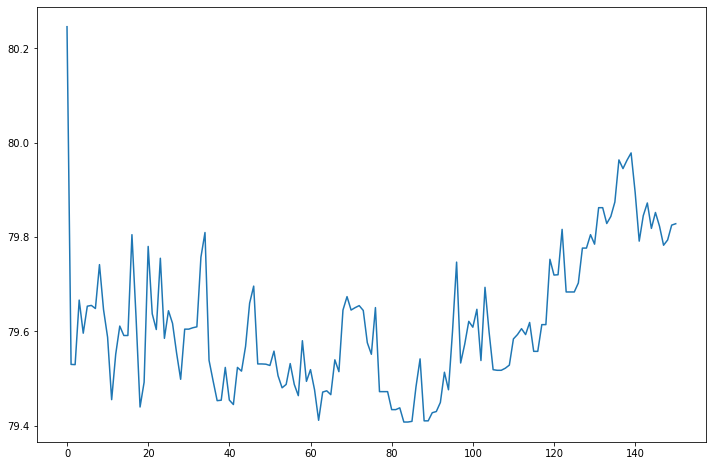

In [100]:
#Plotando o aprendizado
valores_pop = info.select("max")
plt.figure(figsize = (12,8))
plt.plot(valores_pop)
plt.show()